_Version log: Optimisation using Principle Component Analysis._

In [12]:
import sys, time
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy import linalg as spla
from sklearn.linear_model import Lasso
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [13]:
############ STEVEN BRUNTONS RPCA IMPELMENTATION ###############
### I don't fully understand what is going on here but I've added some comments.

def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
def SVT(X,tau): #Singular Value Thresholding?
    U,S,VT = np.linalg.svd(X,full_matrices=0) #Singular value decomposition
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
def RPCA(X): #Robust Principal Component Analysis
    n1,n2 = X.shape #n1 is the number of pixels. n2 is the number of faces.
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1)))) # (mean) normalisation coeffient
    lambd = 1/np.sqrt(np.maximum(n1,n2)) # (standard deivation) normalisation coeffient
    thresh = 10**(-10) * np.linalg.norm(X) #Iterations will continue until the residuals are 10^10 times smaller than the norm of the faces. 
    
    S = np.zeros_like(X) #initialise error matrix. We want this matrix to be sparse.
    Y = np.zeros_like(X) #initialise the Lagrange multiplier matrix. It perturbs the solution at each iteration and represents the rate of change in the optimisation.
    L = np.zeros_like(X) #initialise principal component matrix. We want this matrix to be low rank (represents few dimentions).
    for count in tqdm(range(1000)): #Iterate until converged or a maximum number of iterations has been reached.
        L = SVT(X-S+(1/mu)*Y,1/mu) #1/mu is 4* average pixel value. 
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        if np.linalg.norm(X-L-S) < thresh:
            break
    return L,S,Y

In [14]:
training_dataset = 5

training_interferograms, training_uncertainty = cs.open_training_dataset(training_dataset)

training_interferograms.shape

(900, 200)

In [15]:
start_time = time.time()

components, sparse_errors, lagrange_multiplier = RPCA(training_interferograms.T)
components, sparse_errors, lagrange_multiplier = components.T, sparse_errors.T, lagrange_multiplier.T 

end_time = time.time()

 76%|███████▋  | 763/1000 [02:12<00:41,  5.76it/s]


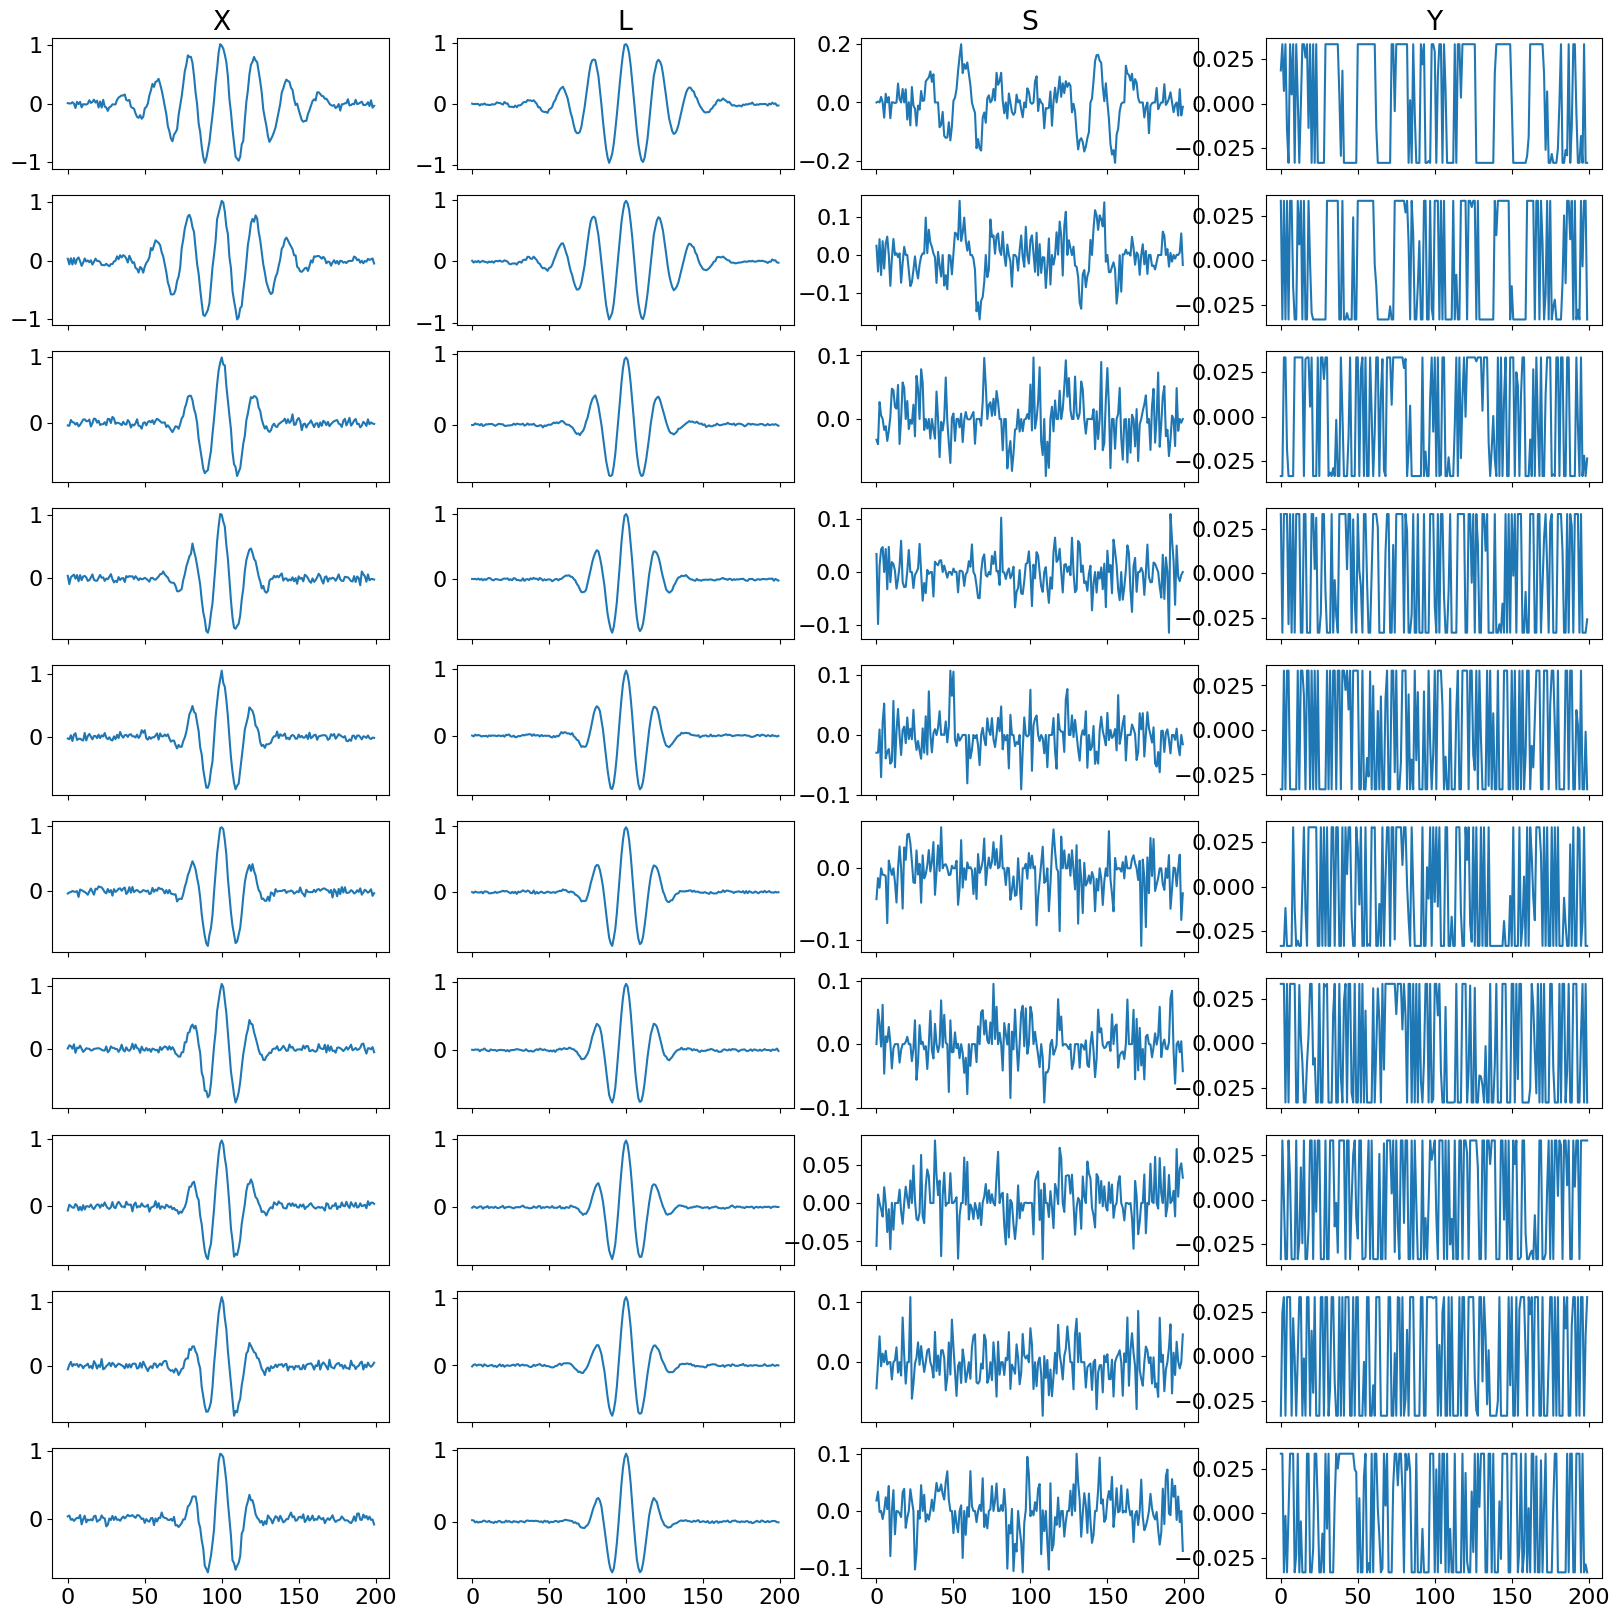

In [16]:
inds = np.arange(10) #np.random.randint(len(training_interferograms), size=10)

fig, axs = plt.subplots(len(inds), 4, figsize= (20, 2*len(inds)), sharex= True)

axs[0,0].set(title= "X")
axs[0,1].set(title= "L")
axs[0,2].set(title= "S")
axs[0,3].set(title= "Y")

for ax_row, k in zip(axs, inds):
    ax_row[0].plot(training_interferograms[k])

    ax_row[1].plot(components[k])

    ax_row[2].plot(sparse_errors[k])

    ax_row[3].plot(lagrange_multiplier[k])

plt.show()

In [17]:
start_time2 = time.time()

Q, R, permutation_matrix = spla.qr(components, pivoting= True)

end_time2 = time.time()
print(end_time +end_time2 -start_time -start_time2)

print("Permutation Matrix (P):")
print(permutation_matrix)

132.66938853263855
Permutation Matrix (P):
[100 111 115 125  71 139  58  82 154 151  91  79  43 104 133  32 107  63
 160  73 103 124  47 172  44  16  24 150 114 164   7  64 127  69  54  37
  65 198 182  61 116  25   5 195  99  12 196  84  74  39  80  14 185 155
  11  87 171 162  53   8   0  68 166 199   6 123 170  75  59 192  97 149
  81 110  30  40  35 169  13  42 193 152  21  17 132 145 188  62  50 137
 144  72 153  27 120  70  38 189 141  52   2 191 113 173  60  46  18 179
 194  10 136 190 148  98 157  95  89 101 106 108  92  93 109 102  94   1
 112  90  88 105  48 119 117 156  85 118  96  78  83  86  77 121 135 183
 129 122 134   4  76 128  41 131 187 147  19 130  34  66 126 167  33 140
  57 186  67 138 181  31 197  15 143  36  20 178 176  55 146 184  56   3
  28  49 142  51  26 165  29 159 158   9  45  22 180 168  23 163 175 161
 177 174]


In [18]:
interferogram_to_test = 11

test_file_name = "1dmockanderrors{0:d}".format(interferogram_to_test)

test_interferogram, test_uncertainties = cs.open_dataset(test_file_name, ".csv")

In [19]:
number_of_detectors = 8
regularization_coeffient = 1e-3

detectors = permutation_matrix[:number_of_detectors]

print(*np.sort(detectors), sep= ",")

58,71,82,100,111,115,125,139


In [20]:
samples = test_interferogram[detectors]
measurement_matrix = components[:,detectors]

lasso = Lasso(alpha= regularization_coeffient)
lasso.fit(measurement_matrix.T, samples)

result = np.matmul(components.T, lasso.coef_)

In [21]:
samples_with_gaps = np.full_like(test_interferogram, np.nan)
samples_with_gaps[detectors] = test_interferogram[detectors]
result2 = cs.compressed_sensing(samples_with_gaps, regularization_coeffient)

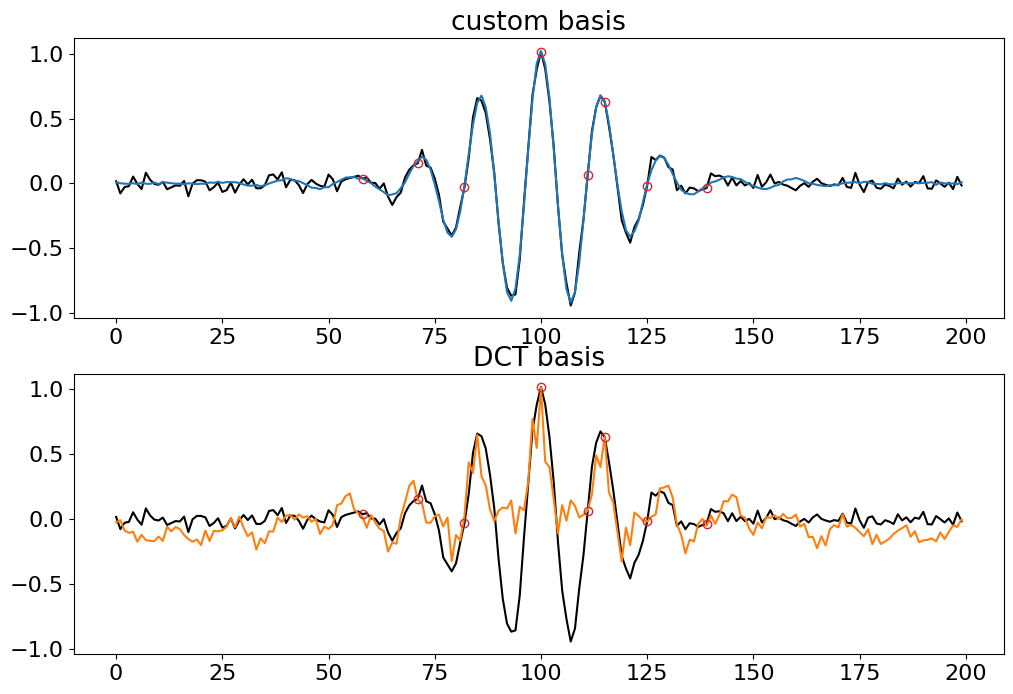

In [22]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(test_interferogram, color= "k")
axs[0].plot(result, color= "tab:blue")
axs[0].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")
axs[0].set(title= "custom basis")

axs[1].plot(test_interferogram, color= "k")
axs[1].plot(result2, color= "tab:orange")
axs[1].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")
axs[1].set(title= "DCT basis")

plt.show()